In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [5]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Test keras version and cuda installation
for each in tf.config.list_physical_devices():
    print(each)
    
print("Current tensorflow ->", tf.__version__)
print("Current keras ->", keras.__version__)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Current tensorflow -> 2.16.1
Current keras -> 3.1.1


In [38]:
# data preparation

num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [39]:
# hyperparameters configuration
learning_rate = 0.001
weight_decay = 0.0001

batch_size = 256
num_epochs = 10  # actual training with 100, 10 for test

image_size = 72  # target image size regards preprocessing
patch_size = 6   # image size of each patched content
num_patches = (image_size // patch_size) **2   #

projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # size of transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024
]   # size of the dense layers of the final head (classification)

In [40]:
# Data augmentation

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [41]:
# MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [53]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108
12


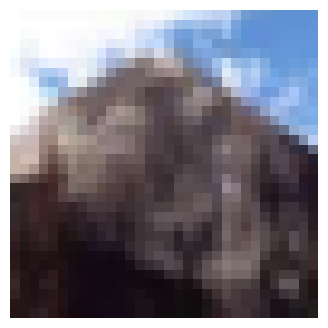

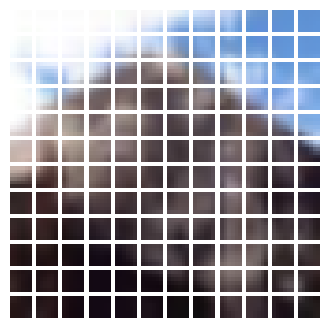

In [59]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")


resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), 
    size=(image_size, image_size)
)

resized_image = tf.cast(resized_image, dtype=tf.float32)


patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
print(n)
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    # print(i, patch.shape)
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))  # each small patch -> 108, 108->(6,6,3)
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")